In [217]:
import pandas as pd
import numpy as np
from datetime import date, datetime
import json
import spacy
import nltk
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import FreqDist
from sklearn.linear_model import LinearRegression

In [2]:
from collections import Counter

Functions

In [3]:
tweet_tokenizer = TweetTokenizer()

In [4]:
stopword = stopwords.words('english')

In [5]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukasfeddern/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [516]:
def tokenize_text(string):
    """
    This takes a string of text, tokenizes it and removes stopwords
    """
    extra_stopwords = ['``', "'s", '•', "n't", '.', 'w/','b/c','w', '/', '', ':', '!', '&amp;', ';', ',']
    tokenized = nltk.word_tokenize(string)
    cleaned = [string.lower() for string in tokenized if string not in extra_stopwords and string not in stopword]
    return cleaned

In [7]:
def extract_ngrams(data, num):
    '''
    input: tokenized list of data, type of ngram
    output: readable ngrams
    '''
    n_grams = ngrams(data, num)
    return [' '.join(grams) for grams in n_grams]

In [8]:
def clean_trigram_text(string):
    """
    This takes a string of text, tokenizes it, removes stopwords, and splits it into trigrams
    """
    extra_stopwords = ['``', "'s", '•', "n't", '.', 'w/','b/c','w', '/', '', ':', '!', '&amp;', ';', ',']
    tokenized = nltk.word_tokenize(string)
    cleaned = [string.lower() for string in tokenized if string not in extra_stopwords and string not in stopword]
    trigrams = extract_ngrams(cleaned, 3)
    return trigrams

In [515]:
def clean_bigram_text(string):
    """
    This takes a string of text, tokenizes it, removes stopwords, and splits it into bigrams
    """
    extra_stopwords = ['``', "'s", '•', "n't", '.', 'w/','b/c','w', '/', '', ':', '!', '&amp;', ';', ',']
    tokenized = nltk.word_tokenize(string)
    cleaned = [string.lower() for string in tokenized if string not in extra_stopwords and string not in stopword]
    bigrams = extract_ngrams(cleaned, 2)
    return bigrams

In [10]:
def apply_ngrams(df):
    # Apply ngram/cleaning functions to the text in the df
    df['trigrams'] = df['tweet'].apply(clean_trigram_text)
    df['bigrams'] = df['tweet'].apply(clean_bigram_text)
    df['tok_text'] = df['tweet'].apply(tokenize_text)
    df['tok_text2'] = df['tweet'].apply(lambda row: tweet_tokenizer.tokenize(row))
    return df

In [11]:
def extract_ngrams(data, num):
    '''
    input: tokenized list of data, type of ngram
    output: readable ngrams
    '''
    n_grams = ngrams(data, num)
    return [' '.join(grams) for grams in n_grams]

In [12]:
def get_hashtags(df):
    '''
    input: dataframe of tweets
    output: pd series of hashtags
    '''
    df['hashtags']=df['tweet'].apply(lambda x: re.findall(r"#(\w+)", x))
    return df

In [514]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [367]:
def freq_analysis(df, search_phrases):
    tweets = []
    general_phrases = ["shooting", "tragedy", "condolences", "thoughts", "prayers", "thoughts prayers","murder", "killing", "shooter", "shooters",
            "armed gunman", "deepest condolences", "victims", "killed", "injured", "families", "heart", "shot",
            "tragic", "enoughisenough", "guncontrol", "gunviolence", "guncontrol", "mass murder", 'grieve', 'gun control', 'heart broken', '2a']


    # For trigram search phrases
    for i in range(len(df.trigrams)):
        if any(x in search_phrases for x in df.trigrams.iloc[i]):
            tweets.append(df.tweet.iloc[i])
        
    # For bigram search phrases
    for j in range(len(df.bigrams)):
        if any(y in search_phrases for y in df.bigrams.iloc[j]) and any(x in general_phrases for x in df.bigrams.iloc[i]):
            tweets.append(df.tweet.iloc[j])

    # For single word searches
    for k in range(len(df.tok_text)):
        if any(z in search_phrases for z in df.tok_text.iloc[k]) and any(x in general_phrases for x in df.tok_text.iloc[k]):
            tweets.append(df.tweet.iloc[k])
    
    tweets = pd.Series(tweets).drop_duplicates().to_list()
    return tweets
    
    

In [276]:
def get_lr(ex, why):
    X = np.array(ex).reshape(-1, 1)
    y = why
    reg = LinearRegression().fit(X, y)
    return reg.score(X, y)

Definition of Dictionary

In [435]:
shooting_keywords = {'Plano':["spencer hight","meredith hight","plano","caleb edwards","deffner",
                              "rushin",'hight','estranged husband', 'north texas'],
                     'Pittsburgh':["pittsburgh","synagogue","bowers","tree life","squirrel hill", "anti-semitism",'pittsburghsynagogue','treeoflife','treeoflifesynagogue',
                                   'showupforshabbat', 'pittsburghshooting', 'pittsburghstrong'],
                     'Las_Vegas':["paddock", "vegas","las vegas","lombardo",'country music event','music festival','vegasstrong', '1Ooctober', 'vegasstrong',
                                'lasvegasstrong','lasvegasshooting', 'prayforvegas'],
                     'SanBernardino':["san bernardino",'bernadino', 'sbstrong', 'prayforsanbernardino', 'sanbernardino'],
                     'Houston':['harris county', 'gilliland', 'valerie jackson', 'dewayne jackson', 'david ray conley', 'conley'],
                     'Odessa':['midland','odessa', 'midland-odessa','west texas','midland-odessa', 'odessastrong', 'odessashooting', 'odessastrong', 'westtexasstrong'],
                     'Bogue_Chitto':['bogue chitto','lincoln county','brookhaven', 'godbolt', 'durr'],
                     'Washington':['washington navy yard', 'navy yard', 'navyyard', 'navyyardshooting'],
                     'Boulder':['boulder','grocery store', 'arvada', 'king soopers', 'boulderstrong', 'boulderproud'],
                     'Virginia':['virginia beach','nettleton','princess anne', 'municipal center', 'virginiabeach', 
                     'cityofvabeach', 'vbremembers', 'vbstrong', 'loveforvb']
                    }

Analysis

In [500]:
Shootings = pd.read_csv("https://raw.githubusercontent.com/khahnmad/Lest-They-Forget/main/v2-sampled_shootings.csv")

In [436]:
summary = dict()
dates = []
corpus = []

for i in shooting_keywords.keys():


    
    Shooting = pd.read_csv(f"Twitter/Twitter_{i}.csv").iloc[:,1:]
    
    Shooting = apply_ngrams(Shooting)

    #Count tweets

    tweets = freq_analysis(Shooting, shooting_keywords[i])
    corpus.append(tweets)
    dates.append(Shooting[Shooting['tweet'].isin(tweets)].date.tolist())
    summary[i] = [len(Shooting), len(tweets)]
    

    
    
    


/opt/homebrew/Caskroom/miniforge/base/envs/env1/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/var/folders/zr/fkpnf7r112g3q4sn6hqvwcmh0000gn/T/ipykernel_30428/2484456300.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tweets = pd.Series(tweets).drop_duplicates().to_list()


In [497]:
summary = {"Las Vegas" if k == "Las_Vegas" else k:v for k,v in summary.items()}
summary = {"San Bernardino" if k == "SanBernardino" else k:v for k,v in summary.items()}
summary = {"Bogue Chitto" if k == "Bogue_Chitto" else k:v for k,v in summary.items()}
summary = {"Washington Navy Yard" if k == "Washington" else k:v for k,v in summary.items()}
summary = {"Virginia Beach" if k == "Virginia" else k:v for k,v in summary.items()}

In [498]:
pd.DataFrame.from_dict(summary, orient='index', columns=["Total Tweets", "Tweets on Topic"]).reset_index()

,index,Total Tweets,Tweets on Topic
0,Plano,51024,1
1,Pittsburgh,40612,237
2,Las Vegas,47363,244
3,San Bernardino,42269,47
4,Houston,43066,0
5,Odessa,55654,57
6,Bogue Chitto,48823,0
7,Washington Navy Yard,35082,120
8,Boulder,72483,171
9,Virginia Beach,59531,23


In [501]:
Count = pd.DataFrame.from_dict(summary, orient='index', columns=["Total Tweets", "Tweets on Topic"]).reset_index().rename(columns={'index':'City Or County'})

In [502]:
Shootings = Shootings.merge(Count, how='left', on='City Or County')

In [503]:
Shootings

,City Or County,Shooting Name Sum,Shooting Sum,Shooter Name Sum,Incident ID,Incident Date,State,Address,# Killed,# Injured,...,Gender of Killed,Avg Age of Killed,Majority racialized victims,Shooter Name,Shooter Age,Shooter Race,Shooter after the shooting,Cop Killed/ injured,Total Tweets,Tweets on Topic
0,San Bernardino,228,5101,2017,456893,12/2/2015 0:00,California,1365 South Waterman Ave,16,19,...,0.357143,41.928571,0,Rizwan Farook and Tashfeen Malik,28,pakistani,killed by police,2,42269,47
1,Houston,2,2401,0,390526,8/8/2015 0:00,Texas,2211 Falling Oaks,8,0,...,0.250000,18.250000,1,David Ray Conley,48,black,arrested by police,0,43066,0
2,Washington Navy Yard,51,928,489,480366,9/16/2013 0:00,District of Columbia,1336 Isaac Hull Ave,13,3,...,0.285714,57.714286,0,Aaron Alexis,34,black,killed by police,1,35082,120
3,Boulder,271,9394,357,1958652,3/22/2021 0:00,Colorado,3600 Table Mesa Dr,10,1,...,0.600000,46.600000,0,Ahmad Al Aliwi Al-Issa,21,syrian-american,arrested by police,0,72483,171
4,Odessa,46,5569,493,1492441,8/31/2019 0:00,Texas,8250 TX 191,8,23,...,0.285714,31.857143,1,Seth Aaron Ator,36,white,killed by police,3,55654,57
5,Pittsburgh,56,6669,911,1241819,10/27/2018 0:00,Pennsylvania,5898 Wilkins Ave,11,7,...,0.363636,74.000000,0,Robert Gregory Bowers,46,white,killed by police,4,40612,237
6,Las Vegas,1340,19302,8674,946496,10/1/2017 0:00,Nevada,3950 Las Vegas Blvd S,59,441,...,0.620690,38.379310,0,Stephen Paddock,64,White,Suicide,0,47363,244
7,Plano,4,19345,132,930569,9/10/2017 0:00,Texas,1712 West Spring Creek Parkway,9,1,...,0.375000,27.375000,0,Spencer Hight,32,white,killed by police,0,51024,1
8,Bogue Chitto,0,4035,0,853756,5/27/2017 0:00,Mississippi,2871 Lee Dr,8,1,...,0.500000,37.375000,1,Willie Cory Godbolt,35,black,arrested by police,0,48823,0
9,Virginia Beach,65,11598,381,1410442,5/31/2019 0:00,Virginia,2405 Courthouse Drive,13,4,...,0.416667,51.583333,0,DeWayne Craddock,40,black,killed by police,1,59531,23


In [468]:
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=8)

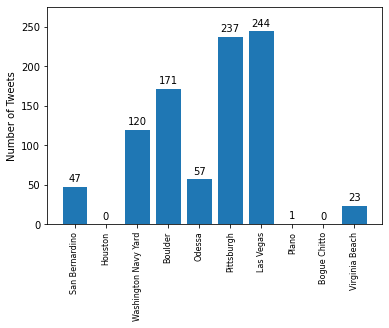

In [470]:
fig, ax = plt.subplots()
ax.set_ylabel('Number of Tweets')
pps = ax.bar(x=[Shootings.iloc[i,0] for i in range(0, len(Shootings))], height=[Shootings.iloc[i,-1] for i in range(0, len(Shootings))])
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width()/2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

plt.ylim(0, 275)
plt.xticks(rotation = 90)
plt.show()

In [534]:
Shootings['Incident Date'] = pd.to_datetime(Shootings['Incident Date'])

In [561]:
days_all = []

for i in range(len(corpus)):
    
    days = {k: [] for k in np.array(range(0,90,3))}

    i_s = Shootings[Shootings['City Or County']==Count.iloc[i,0]]['Incident Date'].index.tolist()[0]


    for j in range(len(corpus[i])):

        d= abs(Shootings[Shootings['City Or County']==Count.iloc[i,0]]['Incident Date'][i_s].date()-pd.to_datetime(dates[i][j]).date()).days
        k_d = np.array(range(0,90,3))[np.array(range(0,90,3)) <= d].max()
        days[k_d].append(corpus[i][j])
    
    days_all.append(days)

    

In [536]:
daily_all = []
for i in range(len(corpus)):
    
    days = {k: [] for k in np.array(range(0,92,1))}

    i_s = Shootings[Shootings['City Or County']==Count.iloc[i,0]]['Incident Date'].index.tolist()[0]


    for j in range(len(corpus[i])):

        d= abs(Shootings[Shootings['City Or County']==Count.iloc[i,0]]['Incident Date'][i_s].date()-pd.to_datetime(dates[i][j]).date()).days
        k_d = np.array(range(0,92,1))[np.array(range(0,92,1)) <= d].max()
        days[k_d].append(corpus[i][j])
    
    daily_all.append(days)

In [579]:
days_all_num = []

for i in range(len(days_all)):

    days_num = {k: 0 for k in np.array(range(0,90,3))}

    for j in days_all[i].keys():

        days_num[j] = len(days_all[i][j])
    
    days_all_num.append(days_num)
            

In [570]:
daily_all_num = []

for i in range(len(daily_all)):

    daily_num = {k: 0 for k in np.array(range(0,92,1))}

    for j in daily_all[i].keys():

        daily_num[j] = len(daily_all[i][j])
    
    daily_all_num.append(daily_num)

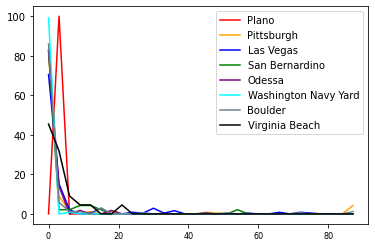

In [591]:
color = ['red', 'orange', 'blue', 'green', 'yellow', 'purple', 'fuchsia', 'aqua', 'slategrey', 'black']
for i in range(0,10):
    try:
        plt.plot(pd.DataFrame(days_all_num, index=Count['City Or County']).columns.tolist(), [x*100 / sum(pd.DataFrame(days_all_num, index=Count['City Or County']).iloc[i,:].tolist()) for x in pd.DataFrame(days_all_num, index=Count['City Or County']).iloc[i,:].tolist()], color=color[i],
        label = Count['City Or County'][i])
    except ZeroDivisionError:
        pass
plt.legend(loc="upper right")
plt.show()

In [589]:
cumsum = []
for i in range(0,10):
    try:
        cumsum.append([x*100 / sum(pd.DataFrame(daily_all_num, index=Count['City Or County']).iloc[i,:].tolist()) for x in pd.DataFrame(daily_all_num, index=Count['City Or County']).cumsum(axis=1).iloc[i,:].tolist()])

    except ZeroDivisionError:
        pass

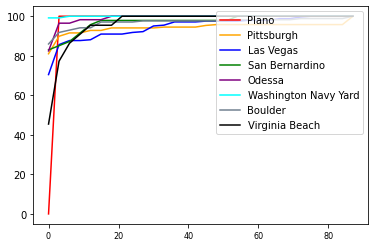

In [585]:
color = ['red', 'orange', 'blue', 'green', 'yellow', 'purple', 'fuchsia', 'aqua', 'slategrey', 'black']
for i in range(0,10):
    try:
        plt.plot(pd.DataFrame(days_all_num, index=Count['City Or County']).columns.tolist(), [x*100 / sum(pd.DataFrame(days_all_num, index=Count['City Or County']).iloc[i,:].tolist()) for x in pd.DataFrame(days_all_num, index=Count['City Or County']).cumsum(axis=1).iloc[i,:].tolist()], color=color[i],
        label = Count['City Or County'][i])
    except ZeroDivisionError:
        pass
plt.legend(loc="upper right")
plt.show()

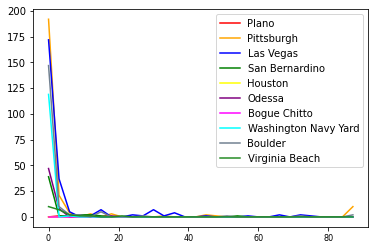

In [586]:
color = ['red', 'orange', 'blue', 'green', 'yellow', 'purple', 'fuchsia', 'aqua', 'slategrey', 'forestgreen']
for i in range(0,10):
    try:
        plt.plot(pd.DataFrame(days_all_num, index=Count['City Or County']).columns.tolist(), pd.DataFrame(days_all_num, index=Count['City Or County']).iloc[i,:].tolist(), color=color[i],
        label = Count['City Or County'][i])
    except ZeroDivisionError:
        pass
plt.legend(loc="upper right")
plt.show()

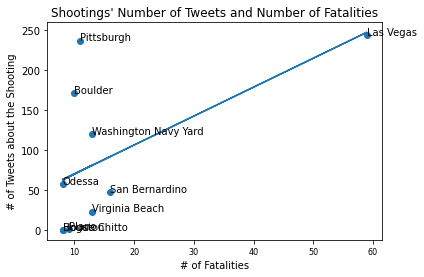

In [491]:
y = Shootings.iloc[:,-1].to_list() # number of tweets
x = Shootings.iloc[:,8].to_list() # number killed
labels = Shootings.iloc[:,0].to_list() # labels

X = np.array(x).reshape(-1, 1)
reg = LinearRegression().fit(X, y)
art_killed_score = reg.score(X,y)

lr_x = x
lr_y = reg.predict(np.array(X))

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(lr_x, lr_y)
ax.set_title("Shootings' Number of Tweets and Number of Fatalities")
ax.set_ylabel('# of Tweets about the Shooting')
ax.set_xlabel('# of Fatalities')
for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

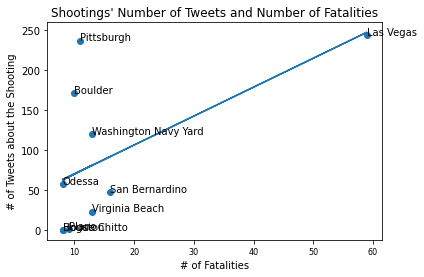

In [492]:
y = Shootings.iloc[:,-1].to_list() # number of tweets
x = Shootings.iloc[:,8].to_list() # number killed
labels = Shootings.iloc[:,0].to_list() # labels

X = np.array(x).reshape(-1, 1)
reg = LinearRegression().fit(X, y)
art_killed_score = reg.score(X,y)

lr_x = x
lr_y = reg.predict(np.array(X))

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(lr_x, lr_y)
ax.set_title("Shootings' Number of Tweets and Number of Fatalities")
ax.set_ylabel('# of Tweets about the Shooting')
ax.set_xlabel('# of Fatalities')
for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

In [504]:
columns = ['Tweets on Topic','Shooting Name Sum', 'Shooting Sum','Shooter Name Sum','# Killed', '# Injured','Gender of Killed',  'Avg Age of Killed', 'Majority racialized victims','Shooter Age']

regression_prep = Shootings.loc[:,columns]
df = pd.DataFrame(columns=['Tweets on Topic','Shooting Name Sum', 'Shooting Sum','Shooter Name Sum',
                           '# Killed', '# Injured','Gender of Killed',  'Avg Age of Killed',
                           'Majority racialized victims','Shooter Age'])
for column in columns:
    for copy in columns[:]:
        h=regression_prep[copy]
        j=regression_prep[column]
        lr= get_lr(regression_prep[column], regression_prep[copy])
        df.loc[copy, column] = lr
    

In [506]:
sim = []
for i in list(range(len(Shootings))):
    sim_i = [0,0,0,0,0,0,0,0,0,0]
    for j in list(range(len(Shootings))):
        if i != j:
            if Shootings.iloc[i,6] == Shootings.iloc[j,6]:
                same_state = 1
            else: 
                same_state = 0
            no_killed = abs(Shootings.iloc[i,8]-Shootings.iloc[j,8])
            no_injured = abs(Shootings.iloc[i,9]-Shootings.iloc[j,9])
            total_victims = abs((Shootings.iloc[i,8]+Shootings.iloc[i,9])-(Shootings.iloc[j,8]+Shootings.iloc[j,9]))
            if Shootings.iloc[i,10] == Shootings.iloc[j,10]:
                same_location = 1
            else:
                same_location = 0
            gender_killed = abs(Shootings.iloc[i,11]-Shootings.iloc[j,11])
            age_killed = abs(Shootings.iloc[i,12] - Shootings.iloc[j,12])
            race_killed = abs(Shootings.iloc[i,13] - Shootings.iloc[j,13])
            shooter_age = abs(Shootings.iloc[i,15] - Shootings.iloc[j,15])
            if Shootings.iloc[i,16] == Shootings.iloc[j,16]:
                same_race = 1
            else:
                same_race = 0
            if Shootings.iloc[i,17] == Shootings.iloc[j,17]:
                same_after = 1
            else:
                same_after = 0
            summary = [same_state, no_killed, no_injured, total_victims, same_location, gender_killed, age_killed,
               race_killed, shooter_age, same_race, same_after]
            importance_vec = [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
            similarity_count = 0
            for k in range(len(summary)):
                multiply = summary[k]*importance_vec[k]
                similarity_count += multiply
            sim_i[j] = similarity_count
    sim.append(sim_i)


In [622]:
LasVegasA = pd.read_excel ('Las_Vegas.xlsx')

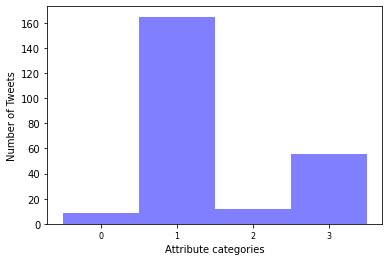

In [652]:
fig, ax = plt.subplots()
ax.set_xlabel('Attribute categories')
ax.set_ylabel('Number of Tweets')
plt.hist(LasVegasA.Attributes, bins = np.arange(0, 5)-0.5, facecolor='blue', alpha=0.5)
plt.xticks(np.arange(0,4))
plt.show()


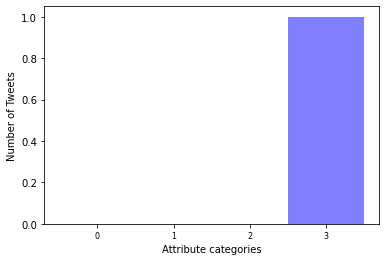

In [653]:
PlanoA = pd.read_excel ('Plano.xlsx')
fig, ax = plt.subplots()
ax.set_xlabel('Attribute categories')
ax.set_ylabel('Number of Tweets')
plt.hist(PlanoA.Attributes, bins = np.arange(0, 5)-0.5, facecolor='blue', alpha=0.5)
plt.xticks(np.arange(0,4))
plt.show()

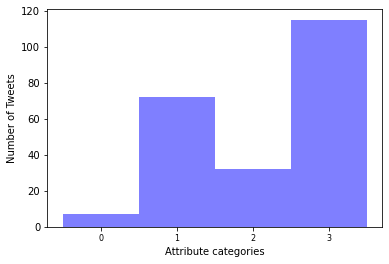

In [655]:
PittA = pd.read_excel ('Pittsburgh.xlsx')
fig, ax = plt.subplots()
ax.set_xlabel('Attribute categories')
ax.set_ylabel('Number of Tweets')
plt.hist(PittA.Attribute, bins = np.arange(0, 5)-0.5, facecolor='blue', alpha=0.5)
plt.xticks(np.arange(0,4))
plt.show()

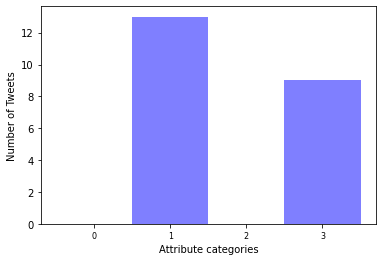

In [658]:
VirgA = pd.read_excel ('Virginia.xlsx')
fig, ax = plt.subplots()
ax.set_xlabel('Attribute categories')
ax.set_ylabel('Number of Tweets')
plt.hist(VirgA.Label, bins = np.arange(0, 5)-0.5, facecolor='blue', alpha=0.5)
plt.xticks(np.arange(0,4))
plt.show()

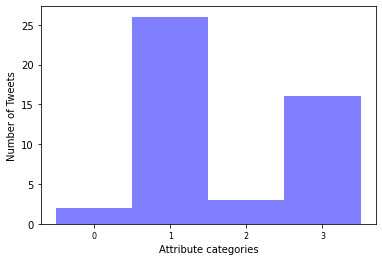

In [659]:
SanBA = pd.read_excel ('San_Bernardino.xlsx')
fig, ax = plt.subplots()
ax.set_xlabel('Attribute categories')
ax.set_ylabel('Number of Tweets')
plt.hist(SanBA.Attributes, bins = np.arange(0, 5)-0.5, facecolor='blue', alpha=0.5)
plt.xticks(np.arange(0,4))
plt.show()

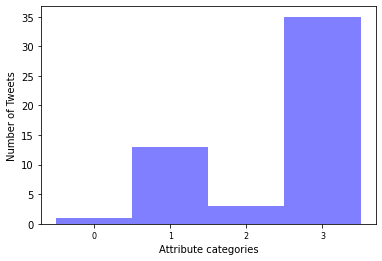

In [662]:
OdA = pd.read_excel ('Odessa.xlsx')
fig, ax = plt.subplots()
ax.set_xlabel('Attribute categories')
ax.set_ylabel('Number of Tweets')
plt.hist(OdA.Attributes, bins = np.arange(0, 5)-0.5, facecolor='blue', alpha=0.5)
plt.xticks(np.arange(0,4))
plt.show()

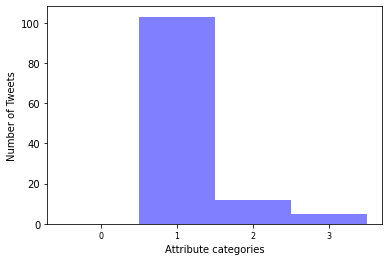

In [663]:
WA = pd.read_excel ('Washington_Navy.xlsx')
fig, ax = plt.subplots()
ax.set_xlabel('Attribute categories')
ax.set_ylabel('Number of Tweets')
plt.hist(WA.Attributes, bins = np.arange(0, 5)-0.5, facecolor='blue', alpha=0.5)
plt.xticks(np.arange(0,4))
plt.show()

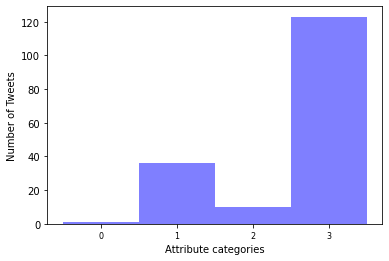

In [664]:
BA = pd.read_excel ('Boulder.xlsx')
fig, ax = plt.subplots()
ax.set_xlabel('Attribute categories')
ax.set_ylabel('Number of Tweets')
plt.hist(BA.Attributes, bins = np.arange(0, 5)-0.5, facecolor='blue', alpha=0.5)
plt.xticks(np.arange(0,4))
plt.show()